In [1]:
%reload_ext nb_black
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

<IPython.core.display.Javascript object>

In [2]:
def missingness_summary(df, print_log=False, sort="none"):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])

    if print_log == True:
        if sort == "none":
            print(summary)
        elif sort == "ascending":
            print(summary.sort_values())
        elif sort == "descending":
            print(summary.sort_values(ascending=False))
        else:
            print("Invalid value for sort parameter.")

    return summary

<IPython.core.display.Javascript object>

In [3]:
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
houseprices_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


<IPython.core.display.Javascript object>

In [4]:
missingness_summary(houseprices_df, print_log=True, sort="descending")
# poolqc
# miscfeature
# alley
# fence
# fireplacequ

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
                   ...   
centralair       0.000000
salecondition    0.000000
heating          0.000000
totalbsmtsf      0.000000
id               0.000000
Length: 81, dtype: float64


id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 81, dtype: float64

<IPython.core.display.Javascript object>

In [5]:
houseprices_df["poolqc"].value_counts(dropna=False)


NaN    1453
Gd        3
Fa        2
Ex        2
Name: poolqc, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
# handle missing poolqc
# poolqc: pool quality
# assuming no pool == no poolqc
houseprices_df.loc[houseprices_df["poolarea"] == 0, "poolqc"].value_counts(dropna=False)

NaN    1453
Name: poolqc, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
# fill missing poolqc with 'none'
houseprices_df["poolqc"] = houseprices_df["poolqc"].fillna(value="none")
houseprices_df["poolqc"].value_counts(dropna=False)

none    1453
Gd         3
Fa         2
Ex         2
Name: poolqc, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
missingness_summary(houseprices_df, print_log=True, sort="descending")


miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
                  ...   
fullbath        0.000000
halfbath        0.000000
bedroomabvgr    0.000000
kitchenabvgr    0.000000
id              0.000000
Length: 81, dtype: float64


id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 81, dtype: float64

<IPython.core.display.Javascript object>

In [9]:
# `miscfeature`: misc feature not handled in other categories
# handle `miscfeature` na's
houseprices_df["miscfeature"].value_counts(dropna=False)

# handle as with `poolqc`

NaN     1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: miscfeature, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
houseprices_df["miscfeature"] = houseprices_df["miscfeature"].fillna(value="none")
houseprices_df["miscfeature"].value_counts(dropna=False)

none    1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: miscfeature, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
# `alley`: type of alley access
# handle `alley` na's
houseprices_df["alley"].value_counts(dropna=False)

# same again

NaN     1369
Grvl      50
Pave      41
Name: alley, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
houseprices_df["alley"] = houseprices_df["alley"].fillna(value="none")
houseprices_df["alley"].value_counts(dropna=False)


none    1369
Grvl      50
Pave      41
Name: alley, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
# rerun missingness report to see what's towards the top of the list
missingness_summary(houseprices_df, print_log=True, sort="descending")

fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagetype      0.055479
garagecond      0.055479
                  ...   
fullbath        0.000000
halfbath        0.000000
bedroomabvgr    0.000000
kitchenabvgr    0.000000
id              0.000000
Length: 81, dtype: float64


id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 81, dtype: float64

<IPython.core.display.Javascript object>

In [14]:
# `fence`: fence quality
# no fence, no problem
# houseprices_df["fence"].value_counts(dropna=False)
houseprices_df["fence"] = houseprices_df["fence"].fillna(value="none")
houseprices_df["fence"].value_counts(dropna=False)

none     1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: fence, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
# `fireplacequ`: fireplace quality
# note, nmumber of fireplaces isn't on the list
houseprices_df["fireplaces"].value_counts(dropna=False)
houseprices_df["fireplacequ"].value_counts(dropna=False)

NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: fireplacequ, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
houseprices_df["fireplacequ"] = houseprices_df["fireplacequ"].fillna(value="none")
houseprices_df["fireplacequ"].value_counts(dropna=False)

none    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: fireplacequ, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
# `lotfrontage` is the last column with 10%+ missingness
# `lotfrontage`: linear feet of street connected to property
# off the bat, not sure how this can be zero
houseprices_df["lotfrontage"].value_counts(dropna=False)

NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: lotfrontage, Length: 111, dtype: int64

<IPython.core.display.Javascript object>

In [18]:
# investigate lot area to see possible values here
houseprices_df.loc[houseprices_df["lotarea"] == 0]
houseprices_df["lotarea"].value_counts(dropna=False)
houseprices_df[["lotarea", "lotfrontage"]].corr()

,lotarea,lotfrontage
lotarea,1.000000,0.426095
lotfrontage,0.426095,1.000000


<IPython.core.display.Javascript object>

In [19]:
# this data is from Ames, Iowa. For lot frontage to be zero, there has to be no lot part which touches a road.
# the only examples of zero lot frontage are in extremely rural areas
# http://www.city-data.com/forum/real-estate/1735402-value-land-without-road-frontage.html
# likewise, i will fill with the average lot frontage

<IPython.core.display.Javascript object>

In [20]:
houseprices_df["lotfrontage"] = houseprices_df["lotfrontage"].fillna(
    value=houseprices_df["lotfrontage"].mean()
)
houseprices_df["lotfrontage"].value_counts(dropna=False)

70.049958     259
60.000000     143
70.000000      70
80.000000      69
50.000000      57
             ... 
106.000000      1
38.000000       1
140.000000      1
138.000000      1
137.000000      1
Name: lotfrontage, Length: 111, dtype: int64

<IPython.core.display.Javascript object>

In [21]:
missingness_summary(
    houseprices_df.filter(like="garage"), print_log=True, sort="descending"
)

# check to see if garage columns with missing values correspond to no garage

garagecond      0.055479
garagequal      0.055479
garagefinish    0.055479
garageyrblt     0.055479
garagetype      0.055479
garagearea      0.000000
garagecars      0.000000
dtype: float64


garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagecars      0.000000
garagearea      0.000000
garagequal      0.055479
garagecond      0.055479
dtype: float64

<IPython.core.display.Javascript object>

In [22]:
houseprices_df["garagearea"].value_counts(dropna=False)


0       81
440     49
576     47
240     38
484     34
        ..
754      1
459      1
458      1
756      1
1418     1
Name: garagearea, Length: 441, dtype: int64

<IPython.core.display.Javascript object>

In [23]:
houseprices_df.loc[houseprices_df["garagearea"] == 0].filter(like="garage")
# as expected. Fill with 0 or none for appropriate data types

,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond
39,None,NaN,None,0,0,None,None
48,None,NaN,None,0,0,None,None
78,None,NaN,None,0,0,None,None
88,None,NaN,None,0,0,None,None
89,None,NaN,None,0,0,None,None
...,...,...,...,...,...,...,...
1349,None,NaN,None,0,0,None,None
1407,None,NaN,None,0,0,None,None
1449,None,NaN,None,0,0,None,None
1450,None,NaN,None,0,0,None,None


<IPython.core.display.Javascript object>

In [24]:
houseprices_df.filter(like="garage").info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   garagetype    1379 non-null   object 
 1   garageyrblt   1379 non-null   float64
 2   garagefinish  1379 non-null   object 
 3   garagecars    1460 non-null   int64  
 4   garagearea    1460 non-null   int64  
 5   garagequal    1379 non-null   object 
 6   garagecond    1379 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 57.1+ KB


<IPython.core.display.Javascript object>

In [25]:
# fill cataegorical garage na's
houseprices_df[
    ["garagetype", "garagefinish", "garagequal", "garagecond"]
] = houseprices_df[["garagetype", "garagefinish", "garagequal", "garagecond"]].fillna(
    value="none"
)

<IPython.core.display.Javascript object>

In [26]:
houseprices_df["garageyrblt"].value_counts(dropna=False)
# how to handle missing years?

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1906.0     1
1927.0     1
1900.0     1
1908.0     1
1933.0     1
Name: garageyrblt, Length: 98, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
# fill numeric garageyrblt na's with avaerage year
houseprices_df["garageyrblt"] = houseprices_df["garageyrblt"].fillna(
    value=houseprices_df["garageyrblt"].mean()
)

<IPython.core.display.Javascript object>

In [28]:
missingness_summary(houseprices_df, print_log=True, sort="descending")
# we see basement categories are missing chronically

bsmtfintype2    0.026027
bsmtexposure    0.026027
bsmtqual        0.025342
bsmtfintype1    0.025342
bsmtcond        0.025342
                  ...   
functional      0.000000
fireplaces      0.000000
fireplacequ     0.000000
garagetype      0.000000
id              0.000000
Length: 81, dtype: float64


id               0.0
mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
                ... 
mosold           0.0
yrsold           0.0
saletype         0.0
salecondition    0.0
saleprice        0.0
Length: 81, dtype: float64

<IPython.core.display.Javascript object>

In [29]:
houseprices_df.filter(like="bsmt").isna().sum()
# I suspect 'bsmtfintype2' is associated with the missing trend for basements

bsmtqual        37
bsmtcond        37
bsmtexposure    38
bsmtfintype1    37
bsmtfinsf1       0
bsmtfintype2    38
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
bsmtfullbath     0
bsmthalfbath     0
dtype: int64

<IPython.core.display.Javascript object>

In [30]:
houseprices_df["bsmtfintype2"].value_counts(dropna=False)


Unf    1256
Rec      54
LwQ      46
NaN      38
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
houseprices_df.loc[houseprices_df["bsmtfintype2"].isna()].filter(like="bsmt")


,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,bsmtfullbath,bsmthalfbath
17,None,None,None,None,0,None,0,0,0,0,0
39,None,None,None,None,0,None,0,0,0,0,0
90,None,None,None,None,0,None,0,0,0,0,0
100,None,None,None,None,0,None,0,0,0,0,0
103,None,None,None,None,0,None,0,0,0,0,0
157,None,None,None,None,0,None,0,0,0,0,0
183,None,None,None,None,0,None,0,0,0,0,0
260,None,None,None,None,0,None,0,0,0,0,0
333,Gd,TA,No,GLQ,1124,None,479,1603,3206,1,0
343,None,None,None,None,0,None,0,0,0,0,0


<IPython.core.display.Javascript object>

In [32]:
houseprices_df.filter(like="bsmt").select_dtypes(include="object").columns.values.tolist()


['bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2']

<IPython.core.display.Javascript object>

In [33]:
bsmt_cat_cols = (
    houseprices_df.filter(like="bsmt")
    .select_dtypes(include="object")
    .columns.values.tolist()
)
# bsmt_cat_cols = list(bsmt_cat_cols)
# type(bsmt_cat_cols)

<IPython.core.display.Javascript object>

In [34]:
houseprices_df[bsmt_cat_cols] = houseprices_df[bsmt_cat_cols].fillna(value="None")


<IPython.core.display.Javascript object>

In [35]:
houseprices_df.filter(like="bsmt").isna().sum()


bsmtqual        0
bsmtcond        0
bsmtexposure    0
bsmtfintype1    0
bsmtfinsf1      0
bsmtfintype2    0
bsmtfinsf2      0
bsmtunfsf       0
totalbsmtsf     0
bsmtfullbath    0
bsmthalfbath    0
dtype: int64

<IPython.core.display.Javascript object>

In [36]:
missingness_summary(houseprices_df, print_log=True, sort="descending")
# so few na's left just drop them

masvnrtype     0.005479
masvnrarea     0.005479
electrical     0.000685
saleprice      0.000000
foundation     0.000000
                 ...   
functional     0.000000
fireplaces     0.000000
fireplacequ    0.000000
garagetype     0.000000
id             0.000000
Length: 81, dtype: float64


id               0.0
mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
                ... 
mosold           0.0
yrsold           0.0
saletype         0.0
salecondition    0.0
saleprice        0.0
Length: 81, dtype: float64

<IPython.core.display.Javascript object>

In [37]:
houseprices_df.shape


(1460, 81)

<IPython.core.display.Javascript object>

In [38]:
houseprices_df = houseprices_df.dropna()
houseprices_df.shape

(1451, 81)

<IPython.core.display.Javascript object>

In [39]:
houseprices_df.isna().sum()


id               0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
                ..
mosold           0
yrsold           0
saletype         0
salecondition    0
saleprice        0
Length: 81, dtype: int64

<IPython.core.display.Javascript object>

<AxesSubplot:>

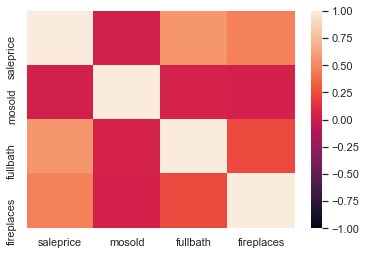

<IPython.core.display.Javascript object>

In [40]:
sns.heatmap(
    houseprices_df[["saleprice", "mosold", "fullbath", "fireplaces"]].corr(),
    vmin=-1,
    vmax=1,
)

In [41]:
houseprices_df["total_baths"] = houseprices_df["fullbath"] + (
    0.5 * houseprices_df["halfbath"]
)

<IPython.core.display.Javascript object>

In [42]:
# used value_counts to inspect the columns
cols_of_interest = [
    "saleprice",
    "mszoning",
    "bldgtype",
    "housestyle",
    "overallcond",
    "total_baths",  # some places have 0 bathrooms?
    "salecondition",
    "lotarea",
    "lotfrontage",
    "yearremodadd",
    "yearbuilt",
    "garagearea",
]


<IPython.core.display.Javascript object>

In [43]:
houses = houseprices_df[cols_of_interest]
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   saleprice      1451 non-null   int64  
 1   mszoning       1451 non-null   object 
 2   bldgtype       1451 non-null   object 
 3   housestyle     1451 non-null   object 
 4   overallcond    1451 non-null   int64  
 5   total_baths    1451 non-null   float64
 6   salecondition  1451 non-null   object 
 7   lotarea        1451 non-null   int64  
 8   lotfrontage    1451 non-null   float64
 9   yearremodadd   1451 non-null   int64  
 10  yearbuilt      1451 non-null   int64  
 11  garagearea     1451 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 124.7+ KB


<IPython.core.display.Javascript object>

In [44]:
houses.describe()


,saleprice,overallcond,total_baths,lotarea,lotfrontage,yearremodadd,yearbuilt,garagearea
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,180624.101999,5.579600,1.752929,10507.808408,70.031592,1984.760165,1971.092350,472.525155
std,79312.128273,1.113415,0.635542,9992.987081,22.040937,20.651334,30.190266,214.171752
min,34900.000000,1.000000,0.000000,1300.000000,21.000000,1950.000000,1872.000000,0.000000
25%,129900.000000,5.000000,1.000000,7537.500000,60.000000,1966.000000,1954.000000,327.500000
50%,162500.000000,5.000000,2.000000,9477.000000,70.049958,1993.000000,1972.000000,478.000000
75%,214000.000000,6.000000,2.500000,11600.000000,79.000000,2004.000000,2000.000000,576.000000
max,755000.000000,9.000000,3.500000,215245.000000,313.000000,2010.000000,2010.000000,1418.000000


<IPython.core.display.Javascript object>

In [45]:
plot_list = [
    "saleprice",
    # "overallcond",
    "total_baths",
    "lotarea",  # consider transformation
    "lotfrontage",
    "yearremodadd",
    "yearbuilt",
    "garagearea",  # looks like a good predictor, maybe stratified
    # "salecondition",
    "bldgtype",
]

<IPython.core.display.Javascript object>

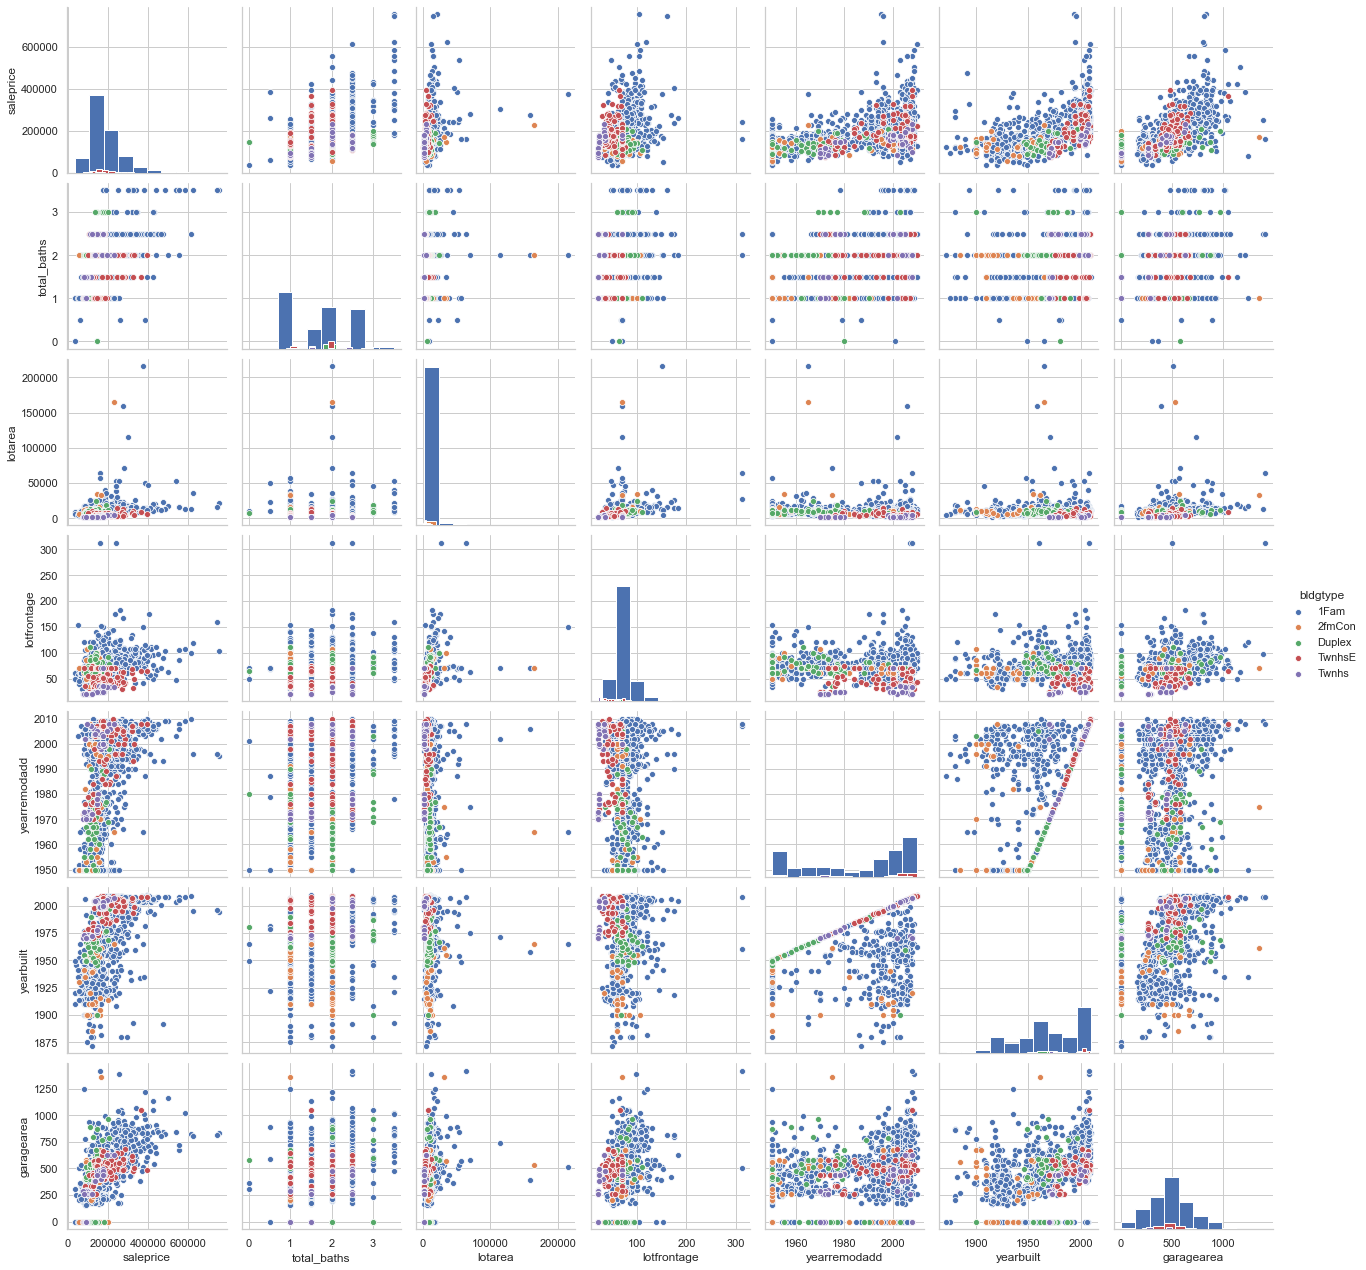

<IPython.core.display.Javascript object>

In [46]:
sns.pairplot(houses[plot_list], hue="bldgtype", diag_kind="hist")


In [47]:
# make dummies for categorical variables
cat_cols = houses.select_dtypes(include="object").columns.values.tolist()

houses_dummied = pd.get_dummies(houses, drop_first=True)

<IPython.core.display.Javascript object>

In [48]:
X = houses_dummied.drop(columns=["saleprice"])
y = houses_dummied["saleprice"]

<IPython.core.display.Javascript object>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

<IPython.core.display.Javascript object>

In [50]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [51]:
y_pred_train = model.predict(X_train)


<IPython.core.display.Javascript object>

In [52]:
model.score(X_train, y_train)


0.6198998671317267

<IPython.core.display.Javascript object>

In [53]:
model.score(X_test, y_test)


0.6554504926305765

<IPython.core.display.Javascript object>

In [54]:
print(model.intercept_)
print(model.coef_)

-1680365.5753165078
[ 5.76735491e+03  4.05359612e+04  8.75787865e-01  3.01357795e+02
  4.20951175e+02  4.17408284e+02  1.16930943e+02 -5.99650536e+03
  2.38456322e+04  2.08084481e+04  1.41389753e+04 -1.74624134e+04
 -4.66412492e+04 -1.64313815e+04  8.36080322e+02  1.11876583e+04
 -7.66094862e+03  3.70377301e+04  1.39296400e+04 -1.07850641e+04
 -1.47239166e+04 -2.24781133e+04  2.81727712e+04  3.63923188e+04
 -3.20062270e+03  4.23169116e+03  3.20260068e+04]


<IPython.core.display.Javascript object>